In [62]:
%matplotlib inline
from matplotlib import style
style.use('fivethirtyeight')
import matplotlib.pyplot as plt

In [63]:
import numpy as np
import pandas as pd

In [64]:
import datetime as dt

# Reflect Tables into SQLAlchemy ORM

In [65]:
# Python SQL toolkit and Object Relational Mapper
import sqlalchemy
from sqlalchemy.ext.automap import automap_base
from sqlalchemy.orm import Session
from sqlalchemy import create_engine, func, inspect

In [66]:
engine = create_engine("sqlite:///Resources/hawaii.sqlite")

In [67]:
# reflect an existing database into a new model
Base = automap_base()
# reflect the tables
Base.prepare(engine, reflect=True)

In [68]:
# We can view all of the classes that automap found
Base.classes.keys()

['measurement', 'station']

In [69]:
# Save references to each table
Measurement = Base.classes.measurement
Station = Base.classes.station

In [70]:
# Create our session (link) from Python to the DB
session = Session(engine)

# Exploratory Climate Analysis

id INTEGER
station TEXT
date TEXT
prcp FLOAT
tobs FLOAT
id INTEGER
station TEXT
name TEXT
latitude FLOAT
longitude FLOAT
elevation FLOAT
Query Date:  2016-08-23


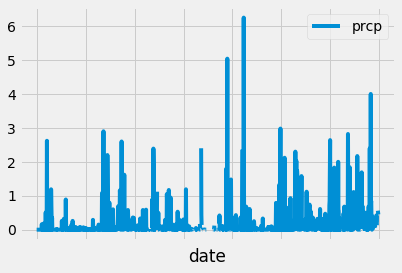

In [94]:
# Design a query to retrieve the last 12 months of precipitation data and plot the results

# Use inspector to check the table's columns

inspector = inspect(engine)

columns = inspector.get_columns('measurement')
for column in columns:
    print(column["name"], column["type"])
    
columns = inspector.get_columns('station')
for column in columns:
    print(column["name"], column["type"])

# Calculate the date 1 year ago from the last data point in the database
# Latest Date
session.query(Measurement.date).order_by(Measurement.date.desc()).first()

query_date = dt.date(2017, 8, 23) - dt.timedelta(days=365)
print("Query Date: ", query_date)

# Perform a query to retrieve the data and precipitation scores
precipitation = session.query(Measurement.date, Measurement.prcp).\
filter(Measurement.date >= "2016-8-23").\
filter(Measurement.date <= "2017-8-23").all()

# Save the query results as a Pandas DataFrame and set the index to the date column
df = pd.DataFrame(precipitation, columns = ["date", "prcp"])
df.set_index("date",inplace = True)
df = df[["prcp"]]
df.head()
# Use Pandas Plotting with Matplotlib to plot the data
df.plot(x_compat=True)

In [95]:
# Use Pandas to calcualte the summary statistics for the precipitation data
df.describe()

,prcp
count,1267.000000
mean,0.165927
std,0.453913
min,0.000000
25%,0.000000
50%,0.000000
75%,0.105000
max,6.250000


In [99]:
# Design a query to show how many stations are available in this dataset?
stations = session.query(func.count(Station.station)).all()
stations

[(9)]

In [101]:
# What are the most active stations? (i.e. what stations have the most rows)?
# List the stations and the counts in descending order.
ActiveStations = session.query(Measurement.station, func.count(Measurement.station)).\
               group_by(Measurement.station).\
               order_by(func.count(Measurement.station).desc()).\
               all()
ActiveStations

[('USC00519281', 2772),
 ('USC00519397', 2724),
 ('USC00513117', 2709),
 ('USC00519523', 2669),
 ('USC00516128', 2612),
 ('USC00514830', 2202),
 ('USC00511918', 1979),
 ('USC00517948', 1372),
 ('USC00518838', 511)]

In [103]:
# Using the station id from the previous query, calculate the lowest temperature recorded, 
# highest temperature recorded, and average temperature most active station?
TempStatistics = session.query(func.min(Measurement.tobs), func.max(Measurement.tobs), func.avg(Measurement.tobs)).all()
TempStatistics

[(53.0, 87.0, 73.09795396419437)]

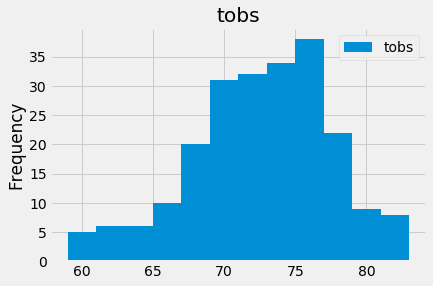

In [114]:
# Choose the station with the highest number of temperature observations.
# Query the last 12 months of temperature observation data for this station and plot the results as a histogram
highest_obs = session.query(Measurement.tobs).\
filter(Measurement.date >= "2016-8-23").\
filter(Measurement.date <= "2017-8-23").\
filter(Measurement.station =="USC00519281").\
all()

highest_obs_df = pd.DataFrame(highest_obs)

fig, ax = plt.subplots()
highest_obs_df.hist(bins = 12,ax = ax)
plt.ylabel("Frequency")
ax.legend(["tobs"])


In [116]:
# This function called `calc_temps` will accept start date and end date in the format '%Y-%m-%d' 
# and return the minimum, average, and maximum temperatures for that range of dates
def calc_temps(start_date, end_date):
    """TMIN, TAVG, and TMAX for a list of dates.
    
    Args:
        start_date (string): A date string in the format %Y-%m-%d
        end_date (string): A date string in the format %Y-%m-%d
        
    Returns:
        TMIN, TAVE, and TMAX
    """
    
    return session.query(func.min(Measurement.tobs), func.avg(Measurement.tobs), func.max(Measurement.tobs)).\
        filter(Measurement.date >= start_date).filter(Measurement.date <= end_date).all()

# function usage example
print(calc_temps('2012-02-28', '2012-03-05'))

[(62.0, 69.57142857142857, 74.0)]


In [118]:
# Use your previous function `calc_temps` to calculate the tmin, tavg, and tmax 
# for your trip using the previous year's data for those same dates.
temperatures = calc_temps('2016-08-23', '2017-08-23')
print(temperatures)

[(58.0, 74.59058295964125, 87.0)]


Text(0.5,1,'Trip Avg Temp')

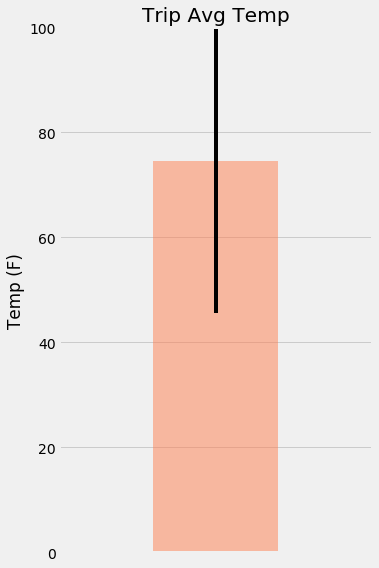

In [124]:
# Plot the results from your previous query as a bar chart. 
# Use "Trip Avg Temp" as your Title
# Use the average temperature for the y value
# Use the peak-to-peak (tmax-tmin) value as the y error bar (yerr)
min = temperatures[0][0]
avg = temperatures[0][1]
max = temperatures[0][2]
peak_to_peak = max - min

fig, ax = plt.subplots(figsize=(5,9))
plt.bar(1,height= avg, yerr = peak_to_peak, color='coral',alpha=0.5)
plt.xticks([])
plt.xlim(0,2)
plt.ylim(0,100)
plt.ylabel("Temp (F)")
plt.title("Trip Avg Temp")

In [126]:
## Calculate the rainfall per weather station for your trip dates using the previous year's matching dates.
# Sort this in descending order by precipitation amount and list the station, name, latitude, longitude, and elevation
trip = session.query(Station.station, Station.name, Station.latitude, Station.longitude, Station.elevation,\
                     func.sum(Measurement.prcp)).filter(Measurement.date >= "2016-08-23").\
                     filter(Measurement.date <="2017-08-23").\
                     filter(Measurement.station == Station.station).\
                     group_by(Station.station).order_by(func.sum(Measurement.prcp).desc()).all()

print(trip)


[('USC00516128', 'MANOA LYON ARBO 785.2, HI US', 21.3331, -157.8025, 152.4, 147.81000000000006), ('USC00519281', 'WAIHEE 837.5, HI US', 21.45167, -157.84888999999998, 32.9, 70.03000000000003), ('USC00513117', 'KANEOHE 838.1, HI US', 21.4234, -157.8015, 14.6, 48.510000000000026), ('USC00519523', 'WAIMANALO EXPERIMENTAL FARM, HI US', 21.33556, -157.71139, 19.5, 38.01), ('USC00514830', 'KUALOA RANCH HEADQUARTERS 886.9, HI US', 21.5213, -157.8374, 7.0, 33.239999999999995), ('USC00519397', 'WAIKIKI 717.2, HI US', 21.2716, -157.8168, 3.0, 16.089999999999986), ('USC00517948', 'PEARL CITY, HI US', 21.3934, -157.9751, 11.9, 4.59)]


## Optional Challenge Assignment

In [20]:
# Create a query that will calculate the daily normals 
# (i.e. the averages for tmin, tmax, and tavg for all historic data matching a specific month and day)

def daily_normals(date):
    """Daily Normals.
    
    Args:
        date (str): A date string in the format '%m-%d'
        
    Returns:
        A list of tuples containing the daily normals, tmin, tavg, and tmax
    
    """
    
    sel = [func.min(Measurement.tobs), func.avg(Measurement.tobs), func.max(Measurement.tobs)]
    return session.query(*sel).filter(func.strftime("%m-%d", Measurement.date) == date).all()
    
daily_normals("01-01")

[(62.0, 69.15384615384616, 77.0)]

In [21]:
# calculate the daily normals for your trip
# push each tuple of calculations into a list called `normals`

# Set the start and end date of the trip

# Use the start and end date to create a range of dates

# Stip off the year and save a list of %m-%d strings

# Loop through the list of %m-%d strings and calculate the normals for each date


[(62.0, 69.15384615384616, 77.0),
 (60.0, 69.39622641509433, 77.0),
 (62.0, 68.9090909090909, 77.0),
 (58.0, 70.0, 76.0),
 (56.0, 67.96428571428571, 76.0),
 (61.0, 68.96491228070175, 76.0),
 (57.0, 68.54385964912281, 76.0)]

In [22]:
# Load the previous query results into a Pandas DataFrame and add the `trip_dates` range as the `date` index


,tmin,tavg,tmax
date,,,
2018-01-01,62.0,69.153846,77.0
2018-01-02,60.0,69.396226,77.0
2018-01-03,62.0,68.909091,77.0
2018-01-04,58.0,70.000000,76.0
2018-01-05,56.0,67.964286,76.0


<IPython.core.display.Javascript object>


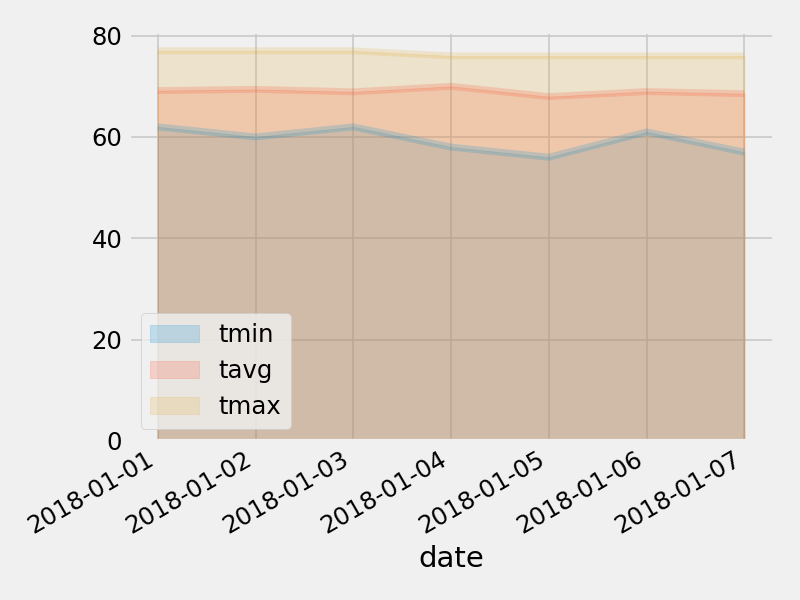

In [23]:
# Plot the daily normals as an area plot with `stacked=False`
